In [1]:
# %%
import os
import sys
import numpy as np
from numpy.random import default_rng
from filelock import FileLock
from pathlib import Path
import pathlib
sys.path.append("..")
# %%
# DATA_PATH = pathlib.Path(__file__).resolve().parent.parent.joinpath("testing/dsprite")
DATA_PATH = Path("../testing/dsprite")

def load_dsprite_dataset():
    with FileLock("./data.lock"):
        dataset_zip = np.load(
            DATA_PATH.joinpath("dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"),
            allow_pickle=True,
            encoding="bytes",
        )
    imgs = dataset_zip["imgs"]
    metadata = dataset_zip["metadata"][()]
    latents_sizes = metadata[b"latents_sizes"]
    latents_bases = np.concatenate(
        (latents_sizes[::-1].cumprod()[::-1][1:], np.array([1]))
    )
    return imgs, latents_bases


def image_id(latent_bases, posX_id_arr, posY_id_arr):
    data_size = posX_id_arr.shape[0]
    color_id_arr = np.zeros(data_size, dtype=int)
    shape_id_arr = np.full(data_size, 2, dtype=int)
    scale_id_arr = np.zeros(data_size, dtype=int)
    orientation_id_arr = np.zeros(data_size, dtype=int)
    indices = np.stack(
        [
            color_id_arr,
            shape_id_arr,
            scale_id_arr,
            orientation_id_arr,
            posX_id_arr,
            posY_id_arr,
        ],
        axis=1,
    )
    return indices.dot(latent_bases)


def structured_outcome_with_mixture_contrast(image: np.ndarray, low=0.5, high=1.5, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.RandomState()
    scale = rng.choice([low, high])
    return scale * image


class GaussianPolicy2D:
    def __init__(self, theta=0.0, beta=0.0, sigma=0.1):
        self.theta = theta
        self.beta = beta
        self.sigma = sigma

    def get_mean(self, U):
        mean1 = U[:, 0] * np.cos(self.theta) + self.beta
        mean2 = U[:, 1] * np.sin(self.theta) + self.beta
        return np.stack([mean1, mean2], axis=1)

    def sample_treatments(self, U):
        mean = self.get_mean(U)
        noise = np.random.normal(0, self.sigma, size=mean.shape)
        return mean + noise

    def get_propensities(self, U, A):
        mean = self.get_mean(U)
        diff = A - mean
        norm_sq = np.sum(diff**2, axis=1)
        d = A.shape[1]
        return (1 / ((2 * np.pi * self.sigma**2) ** (d / 2))) * np.exp(
            -norm_sq / (2 * self.sigma**2)
        )


def generate_logging_data(n, theta=0.0, beta=0.0, sigma=0.1, seed=0):
    rng = np.random.RandomState(seed)
    U = rng.uniform(0, 1, size=(n, 2))
    logging_policy = GaussianPolicy2D(theta, beta, sigma)
    A = logging_policy.sample_treatments(U)
    return U, A, logging_policy


def generate_outcomes(U, A, imgs, latents_bases, rng=None, scenario=None):
    posX = np.clip(((U[:, 0] + 1.5) * 32 / 3).astype(int), 0, 31)
    posY = np.clip(((U[:, 1] + 1.5) * 32 / 3).astype(int), 0, 31)
    image_indices = image_id(latents_bases, posX, posY)

    if rng is None:
        rng = np.random.RandomState()

    Y = []
    for idx in image_indices:
        img = imgs[idx].astype(np.float32)
        if scenario == "III":
            img = structured_outcome_with_mixture_contrast(img, rng=rng)
        Y.append(img)
    return np.stack(Y, axis=0)


def generate_ope_data(U, A, Y, logging_policy, pi, pi_prime, clip_value=1e5):
    pi_density = pi.get_propensities(U, A)
    pi_prime_density = pi_prime.get_propensities(U, A)
    logging_density = logging_policy.get_propensities(U, A)

    w_pi = np.clip(pi_density / logging_density, 0, clip_value)[:, None]
    w_pi_prime = np.clip(pi_prime_density / logging_density, 0, clip_value)[:, None]

    pi_samples = pi.sample_treatments(U)
    pi_prime_samples = pi_prime.sample_treatments(U)

    return dict(
        U=U,
        A=A,
        Y=Y,
        w_pi=w_pi,
        w_pi_prime=w_pi_prime,
        pi_samples=pi_samples,
        pi_prime_samples=pi_prime_samples,
    )

In [2]:
theta_base = 0.0
beta_base = 0.0
sigma = 1.5
pi = GaussianPolicy2D(theta=theta_base, beta=beta_base + 0.5, sigma=sigma)
pi_prime = GaussianPolicy2D(theta=theta_base, beta=beta_base + 0.2, sigma=sigma)

imgs, latents_bases = load_dsprite_dataset()
n = 250
rng = np.random.RandomState(0)
U = rng.uniform(0, 1, size=(n, 2))
logging_policy = pi
A_log = logging_policy.sample_treatments(U)
Y_log = generate_outcomes(U, A_log, imgs, latents_bases, rng=rng)
target_policy = pi_prime
A_tgt = target_policy.sample_treatments(U)
Y_tgt = generate_outcomes(U, A_tgt, imgs, latents_bases, rng=rng)

In [3]:
# %%
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn.metrics import pairwise_kernels, pairwise_distances
import os
from scipy.optimize import minimize
# from embeddings import plugin_embedding_pi, dr_embedding_pi, mmd2_biased, mmd2_unbiased
from environment import (
    logistic_logging_policy,
    reward_nonlinear,
    reward_quadratic,
    find_best_params,
    importance_weights,
    pi0_proba,
    pi_proba,
)
from tqdm import tqdm

In [4]:
def plugin_embedding_pi(
    Y, X, logging_T, pi_samples, reg_lambda, sigmaKX=1.0, sigmaKT=0.5
):
    N = len(Y)
    KX = pairwise_kernels(X, metric="rbf", gamma=1.0 / (sigmaKX))
    KT = pairwise_kernels(logging_T, metric="rbf", gamma=1.0 / (sigmaKT))
    KT_pi = pairwise_kernels(
        logging_T, pi_samples, metric="rbf", gamma=1.0 / (sigmaKT)
    )
    print(KX.shape, KT.shape, KT_pi.shape)
    mu_pi = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N), np.multiply(KX, KT_pi)
    )
    return mu_pi

def dr_embedding_pi(
    Y, X, logging_T, w_pi, pi_samples, reg_lambda, sigmaKX=1.0, sigmaKT=0.5
):
    N = len(Y)
    KX = pairwise_kernels(X, metric="rbf", gamma=1.0 / (sigmaKX))
    KT = pairwise_kernels(logging_T, metric="rbf", gamma=1.0 / (sigmaKT))
    KT_pi = pairwise_kernels(
        logging_T, pi_samples, metric="rbf", gamma=1.0 / (sigmaKT)
    )
    mu_log = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N), np.multiply(KX, KT)
    )
    mu_pi = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N), np.multiply(KX, KT_pi)
    )
    phi = mu_pi + w_pi[:, None] * (np.eye(N) - mu_log)
    return phi


def kernel_herding(Y_support, weights, sigma, num_samples):
    y0 = np.random.randn(Y_support.shape[1])
    res = minimize(
        lambda y: -np.mean(
            np.dot(
                weights.T,
                pairwise_kernels(
                    Y_support,
                    np.atleast_2d(y),
                    metric="rbf",
                    gamma=1.0 / (2 * sigma),
                ),
            )
        ),
        y0,
        method="CG",
        options={"gtol": 1e-6, "disp": False},
    )
    yt = res.x.ravel()

    samples = [yt]
    for t in tqdm(range(2, num_samples + 1)):
        yt_hist = np.array(samples)
        res = minimize(
            lambda y: -np.mean(
                np.dot(
                    weights.T,
                    pairwise_kernels(
                        Y_support,
                        np.atleast_2d(y),
                        metric="rbf",
                        gamma=1.0 / (2 * sigma),
                    ),
                )
            )
            + np.mean(
                pairwise_kernels(
                    yt_hist,
                    np.atleast_2d(y),
                    metric="rbf",
                    gamma=1.0 / (2 * sigma),
                )
            ),
            y0,
            method="CG",
            options={"gtol": 1e-6, "disp": False},
        )
        yt = res.x.ravel()
        samples.append(yt)
    return np.array(samples)



In [5]:
# Importance weights
w_pi = importance_weights(A_log, U, pi_prime.get_propensities, pi.get_propensities)
X_log = U
# Regularization and kernel params
reg_lambda = 1e-5
sigmaKX = np.median(pairwise_distances(X_log)) ** 2 + 1e-8
sigma = np.median(pairwise_distances(Y_log.reshape(n, -1))) ** 2 + 1e-8

# # Embedding and kernel herding
# phi_plugin = plugin_embedding_pi(Y_log.reshape(n, -1), X_log, A_log, A_tgt, reg_lambda, sigmaKX)
phi_dr = dr_embedding_pi(Y_log.reshape(n, -1), X_log, A_log, w_pi, A_tgt, reg_lambda, sigmaKX)
# Y_plugin = kernel_herding(Y_log.reshape(n, -1), phi_plugin, sigma, 100)
Y_dr = kernel_herding(Y_log.reshape(n, -1), phi_dr, sigma, 10)

(100, 100) (100, 100) (100, 100)


100%|██████████| 24/24 [05:07<00:00, 12.82s/it]


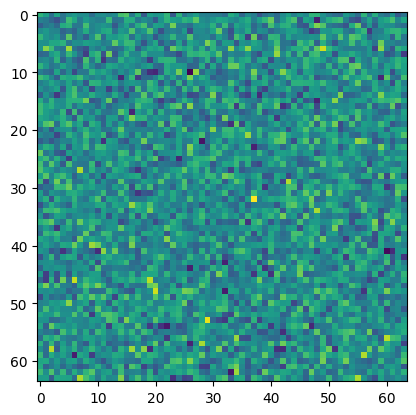

In [6]:
import matplotlib.pyplot as plt
plt.imshow(Y_plugin[-1].reshape(64, 64))

In [11]:
pi.get_propensities(A_log, U)

array([4.82111393e-01, 1.08486578e-01, 5.87770337e-01, 1.04866679e-01,
       6.11382395e-02, 1.08603563e-01, 5.35841269e-04, 4.61031634e-05,
       2.60672649e-01, 4.83643268e-01, 4.52247373e-02, 1.17287630e-04,
       1.63316207e-01, 2.95685391e-01, 2.33343686e-01, 1.63692949e-04,
       1.54247676e-02, 3.55623646e-01, 2.30689310e-01, 2.35845898e-02,
       1.10917480e-03, 3.57553693e-02, 9.20388256e-02, 2.47422865e-02,
       6.01104271e-01, 7.17247531e-02, 6.19617591e-02, 2.04539024e-03,
       5.78322828e-02, 4.00719300e-02, 5.72568190e-02, 1.03089628e-04,
       3.80304706e-01, 4.53368097e-01, 4.56729397e-01, 2.90057763e-01,
       7.61583696e-02, 8.49853689e-02, 6.03360061e-02, 1.56838390e-01,
       2.15435905e-03, 1.49293083e-01, 4.49190439e-01, 1.41214615e-01,
       1.51749382e-01, 1.31629210e-02, 1.33906026e-01, 3.52899371e-02,
       2.28802793e-01, 2.56111389e-02, 5.44706818e-01, 3.02447244e-01,
       3.38448626e-02, 9.77064921e-03, 1.25078341e-04, 2.57332200e-02,
      

In [8]:
Y_log.shape

(100, 64, 64)

In [9]:
Y_plugin.shape

(25, 4096)